A miscallaneous file I used to test how to integreate the models into streamlit

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm

import librosa
import matplotlib.pyplot as plt

device = 'cpu'
# print(f"Using {device} device")
num_segments = 40

In [2]:
class pitch_gen(nn.Module):
    def __init__(self):
        super(pitch_gen, self).__init__()
        self.conv = nn.Conv1d(1, 6, 9, 1, 4)
        self.maxpool = nn.MaxPool1d(3, 3)

        self.fc1 = nn.Linear(13212, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 12)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.maxpool(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        max_values, _ = torch.max(x, dim = 1, keepdim = True)
        x = x / max_values
        return x

In [3]:
# loading in the pitch generation model
pitch_model = pitch_gen().to(device)
saved_model = torch.load('../model/pitch_cnn_model_epoch_14.pth', map_location = torch.device('cpu'))
pitch_model.load_state_dict(saved_model)

<All keys matched successfully>

In [4]:
def normalize_length(y):
    current_length = len(y)
    target_length = 0.29955542442579697 * 22050
    ratio = target_length / current_length
    target_sr = 22050 * ratio
    y = librosa.resample(y, orig_sr=22050, target_sr=target_sr)
    return y

torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])
torch.Size([1, 6606])


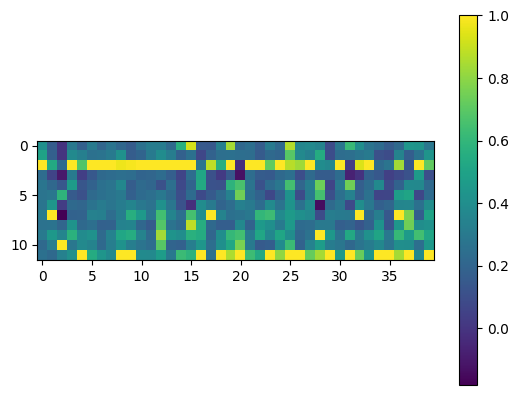

In [13]:
y, sr = librosa.load('../streamlit/output.wav')
onsets = librosa.onset.onset_detect(y = y, sr = sr, units = 'samples')
onsets = np.array(onsets[:40])

# split y into the onset segments
y_segments = np.split(y, onsets)[:-1]

# generate pitch
pitches = []
for segment in y_segments:
    # pitches.append(librosa.feature.chroma_stft(y = segment, sr = 22050, n_chroma = 12, n_fft = len(segment), hop_length = len(segment) + 1))
    tensor = torch.from_numpy(normalize_length(segment)).unsqueeze(0)
    print(tensor.shape)
    pitches.append(pitch_model(tensor).detach().numpy())
pitches = np.array(pitches)

plt.imshow(pitches.squeeze(1).T)
plt.colorbar()

In [14]:
class timbre_gen(nn.Module):
    def __init__(self):
        super(timbre_gen, self).__init__()

        # look at 4 mel bands above and below, and look at 1 time sample before and after
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(9, 3), stride=(1, 1))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(8496, 1024)
        self.fc2 = nn.Linear(1024, 12)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        return x

In [15]:
def create_spectrogram(y):
    current_length = len(y)
    target_length = 0.29955542442579697 * 22050
    ratio = target_length / current_length
    target_sr = 22050 * ratio
    y = librosa.resample(y, orig_sr=22050, target_sr=target_sr)
    mel = librosa.feature.melspectrogram(y = y, sr = target_sr, n_mels = 128)
    return mel

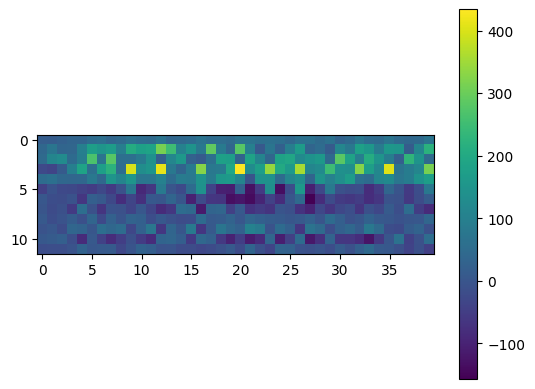

In [18]:
# loading in the timbre generation model
timbre_model = timbre_gen().to(device)
saved_model = torch.load('../model/small_specgram_timbre_model_epoch_60_best.pth', map_location = torch.device('cpu'))
timbre_model.load_state_dict(saved_model['model_state_dict'])

# generate timbre
timbres = []
for segment in y_segments:
    tensor = torch.from_numpy(create_spectrogram(segment)).unsqueeze(0)
    timbres.append(timbre_model(tensor).detach().numpy())
timbres = np.array(timbres)

plt.imshow(timbres.squeeze(1).T)
plt.colorbar()

In [20]:
# genre classification model
class TwoChannelCNN(nn.Module):
    def __init__(self, numClasses):
        super(TwoChannelCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(30720, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, numClasses)

    def forward(self, x):
        # x has shape (batch_size, 2, 50, 12)
        x1 = x[:, 0, :num_segments, :].unsqueeze(1)  # shape: (batch_size, 1, num_segments, 12)
        x2 = x[:, 1, :num_segments, :].unsqueeze(1)  # shape: (batch_size, 1, num_segments, 12)

        out1 = self.layer1(x1)  # shape: (batch_size, 64, 6, 3)
        out2 = self.layer2(x2)  # shape: (batch_size, 64, 6, 3)

        out1 = self.dropout(out1)
        out2 = self.dropout(out2)

        out = torch.cat((out1, out2), dim=1)  # shape: (batch_size, 128, 6, 3)
        out = out.view(out.size(0), -1)  # shape: (batch_size, 128*6*3)
#         print(f'shape: {out.shape}')
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [21]:
# loading in the genre classifier model
# 15 for 15 genres
genre_model = TwoChannelCNN(15).to(device)
trained_model = torch.load('../model/40_segments_epochs_180.pth', map_location = torch.device('cpu'))
genre_model.load_state_dict(trained_model)

<All keys matched successfully>

In [27]:
def prediction_dict(predictions):
    classes = [key for key in {'Rock' : 0, 'Electronic' : 1, 'Pop': 2, 'Blues' : 3, 'Jazz' : 4, 'Rap': 5, \
                'Metal' : 6, 'RnB' : 7, 'Country' : 8, 'Reggae' : 9,  'Folk' : 10,  'World' : 11, \
                'Punk' : 12, 'New' : 13, 'Latin' : 14
    }]
    predictions = predictions.detach().numpy().squeeze()
    predictions = {c: prediction for (c, prediction) in zip(classes, predictions)}

    return dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True))

def create_timbre_and_pitch(filename, n):
    y, sr = librosa.load(filename)
    onsets = librosa.onset.onset_detect(y = y, sr = sr, units = 'samples')
    onsets = np.array(onsets[:n])

    # split y into the onset segments
    y_segments = np.split(y, onsets)[:-1]

    # generate pitch
    pitches = []
    for segment in y_segments:
        # pitches.append(librosa.feature.chroma_stft(y = segment, sr = 22050, n_chroma = 12, n_fft = len(segment), hop_length = len(segment) + 1))
        tensor = torch.from_numpy(normalize_length(segment)).unsqueeze(0)
        pitches.append(pitch_model(tensor).detach().numpy())
    pitches = np.array(pitches).squeeze()

    # generate timbre
    timbres = []
    for segment in y_segments:
        tensor = torch.from_numpy(create_spectrogram(segment)).unsqueeze(0)
        timbres.append(timbre_model(tensor).detach().numpy())
    timbres = np.array(timbres).squeeze()

    return timbres, pitches

In [29]:
timbres, pitches = create_timbre_and_pitch('../streamlit/output.wav', 40)
print(timbres.shape)

timbres = torch.from_numpy(timbres).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, num_segments, 12)
pitches = torch.from_numpy(pitches).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, num_segments, 12)
print(timbres.shape)

input_tensor = torch.cat((timbres, pitches), dim=1)

genre_model.eval()
predictions = genre_model(input_tensor)

(40, 12)
torch.Size([1, 1, 40, 12])
